In [1]:
import pandas as pd
import numpy as np
import os
import random
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, MaxAbsScaler
from sklearn.neighbors import LocalOutlierFactor
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.figure(figsize=(12, 12))

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

In [2]:
data_kpis = pd.read_csv("data/kpis.csv")

oscwd = os.getcwd()

# Load dataframe with BALANCE SHEET data (assets, liabilities and equity)
df_gh = pd.read_csv(os.path.join(oscwd, "data/GH.txt"),
                            dtype = {
                                    'CODIGO': str, 'ENTIDAD': str, 
                                    'Grupo': int
                                    }
                                    # parse_dates=['Periodo'],
                            )
gh_8 = df_gh["CODIGO"][df_gh["Grupo"]==8]

In [3]:
# DELETE GH 8
data_kpis = data_kpis[~data_kpis["ent"].isin(gh_8)]

In [4]:
start = 2015
end = 2015
data = data_kpis[(data_kpis["per"]>=start)&(data_kpis["per"]<=end)]

In [5]:
data = data.drop(columns="per")
data = data.replace(0, np.nan).groupby(["ent", "ind"]).mean("val").reset_index()

In [6]:
data_pivot = data.pivot(index="ent", columns="ind", values="val").fillna(0).reset_index()
# data_pivot_describe = data_pivot.describe()

def scale_data(df, scaler):
    df[df.columns[1:]] = scaler.fit_transform(df[df.columns[1:]])

    return df

def get_corr_matrix(df, method):
    corr_matrix = df[df.columns[1:]].corr(method)

    return corr_matrix

scaler = {
          "maxabs_scaler": MaxAbsScaler(),
          "robust_scaler": RobustScaler()
        }
corr_method = ['pearson', 'kendall', 'spearman']

sns.set(font_scale=0.8, rc={"figure.figsize":(20,20)})

with pd.ExcelWriter('output/data_corr.xlsx') as writer:
    for s, m in [(s, m) for s in scaler for m in corr_method]:
        df_scaled = scale_data(data_pivot, scaler[s])
        corr_matrix = get_corr_matrix(df_scaled, m)
        corr_matrix.style.background_gradient(cmap="coolwarm").to_excel(writer, sheet_name=f"{s}_{m}")
        heatmap = sns.heatmap(corr_matrix, annot=True).set_title(f"corr_matrix_{s}_{m}")
        fig = heatmap.get_figure()
        fig.savefig(f"graph/corr_matrix_{s}_{m}.png", dpi=fig.dpi)
        fig.clf()

    for s in scaler:
        df_scaled = scale_data(data_pivot, scaler[s])
        # for col in df_scaled:
        #    display(f"{col} -> MAX VALUE:{max(df_scaled[col])}, MIN VALUE:{min(df_scaled[col])}")
        df_describe = df_scaled.describe().to_excel(writer, sheet_name=f"describe_{s}")
        fig, ax = plt.subplots()
        ax.boxplot(df_scaled[df_scaled.columns[1:]], vert=False, showmeans=True, meanline=True,
                labels=df_scaled.columns[1:], patch_artist=True,
                medianprops={'linewidth': 2, 'color': 'purple'},
                meanprops={'linewidth': 2, 'color': 'red'})
        plt.title(f"boxplot_{s}")
        fig.savefig(f"graph/boxplot_{s}.png", dpi=fig.dpi)
        fig.clf()

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [7]:
dir_list = [dir for dir in os.listdir("graph")]
# print(dir_list)

row = 1
for dir in dir_list:
    wb = openpyxl.load_workbook("output/data_corr.xlsx")
    if "graph" not in wb.sheetnames:
        ws = wb.create_sheet("graph")
    else:
        ws = wb["graph"]
    image = openpyxl.drawing.image.Image(f"graph/{dir}")
    ws.add_image(image, str(f"A{row}"))
    wb.save("output/data_corr.xlsx")
    row = row + 75

'''with pd.ExcelWriter("output/data_corr.xlsx", mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
    df_scaled.to_excel(writer, sheet_name="graph")'''

'with pd.ExcelWriter("output/data_corr.xlsx", mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:\n    df_scaled.to_excel(writer, sheet_name="graph")'

In [8]:
scaler_name = "maxabs_scaler"
data_scaled = scale_data(data_pivot, scaler=scaler[scaler_name])
data_arr = data_scaled[data_scaled.columns[1:]].to_numpy()
data_arr.shape

(71, 18)

ind,ent,adv_curr_acc_disc_doc_loans,asset_tot_asset,dep_cap_assets,deriv_assets,exp_dep_cap_loans,implied_lending_rate,implied_liable_rate,implied_spread,liquidity_ratio,...,loans_cap_assets,loans_cap_to_banks_assets,net_int_inc_tot_income,net_worth_assets,pers_cred_card_loans,roe,serv_rev_tot_inc,titles_assets,LOF,outlier
48,338,0.415593,0.000000,-0.250599,-0.066564,-0.052926,0.086553,-0.249333,1.000000,-0.034906,...,-0.013884,-0.008960,1.000000,-0.142076,0.116824,-0.425613,1.000000,-0.251662,-2.280304,-1
40,312,-0.308864,-0.007003,-0.339902,0.000000,-0.304049,1.000000,0.092168,-0.155834,0.041355,...,-0.701315,-0.011038,-0.000583,0.299595,0.918749,0.781048,-0.002270,0.103256,-1.976738,-1
56,432,-0.308864,-0.007750,-1.000000,0.000000,0.088719,-0.173563,0.644533,0.025621,-0.129827,...,-1.000000,-0.011038,-0.003273,-0.325347,-0.487652,-0.428351,-0.002410,-0.296574,-1.927945,-1
19,147,-0.177062,-0.007376,-0.853210,-1.000000,-1.000000,0.045612,0.292515,0.118651,1.000000,...,-0.407208,0.053561,-0.004666,0.832566,-0.487556,-0.999716,-0.003105,0.176423,-1.893316,-1
29,269,0.460890,-0.007230,0.045373,0.000000,-0.064432,-0.018020,0.559093,0.011819,0.215207,...,-0.656373,0.113746,-0.004625,0.332211,-0.418268,-0.844527,-0.002910,-0.147323,-1.873158,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,330,0.347281,0.049636,0.046090,-0.006603,0.015649,-0.016544,0.148703,-0.250031,-0.051743,...,0.167328,-0.004893,0.000520,0.117619,0.136906,-0.075140,-0.000161,-0.154970,-0.970642,1
5,17,0.149797,0.208385,0.017998,0.009216,0.023953,-0.032163,0.118441,-0.048906,0.009857,...,-0.026571,-0.009876,-0.000289,0.021004,0.167205,0.081207,-0.000131,0.041051,-0.969632,1
0,7,0.310240,0.266902,0.014594,-0.057093,0.031616,-0.034546,-0.042531,-0.036810,-0.021088,...,0.000251,-0.010301,-0.000790,-0.053497,0.259692,0.124927,0.000296,0.000000,-0.967968,1
8,29,0.108774,0.116972,0.154100,0.002201,0.037637,-0.051610,0.138838,-0.030533,-0.023537,...,0.115225,-0.010393,0.001840,-0.025618,-0.049637,-0.128138,-0.001433,-0.051850,-0.967810,1


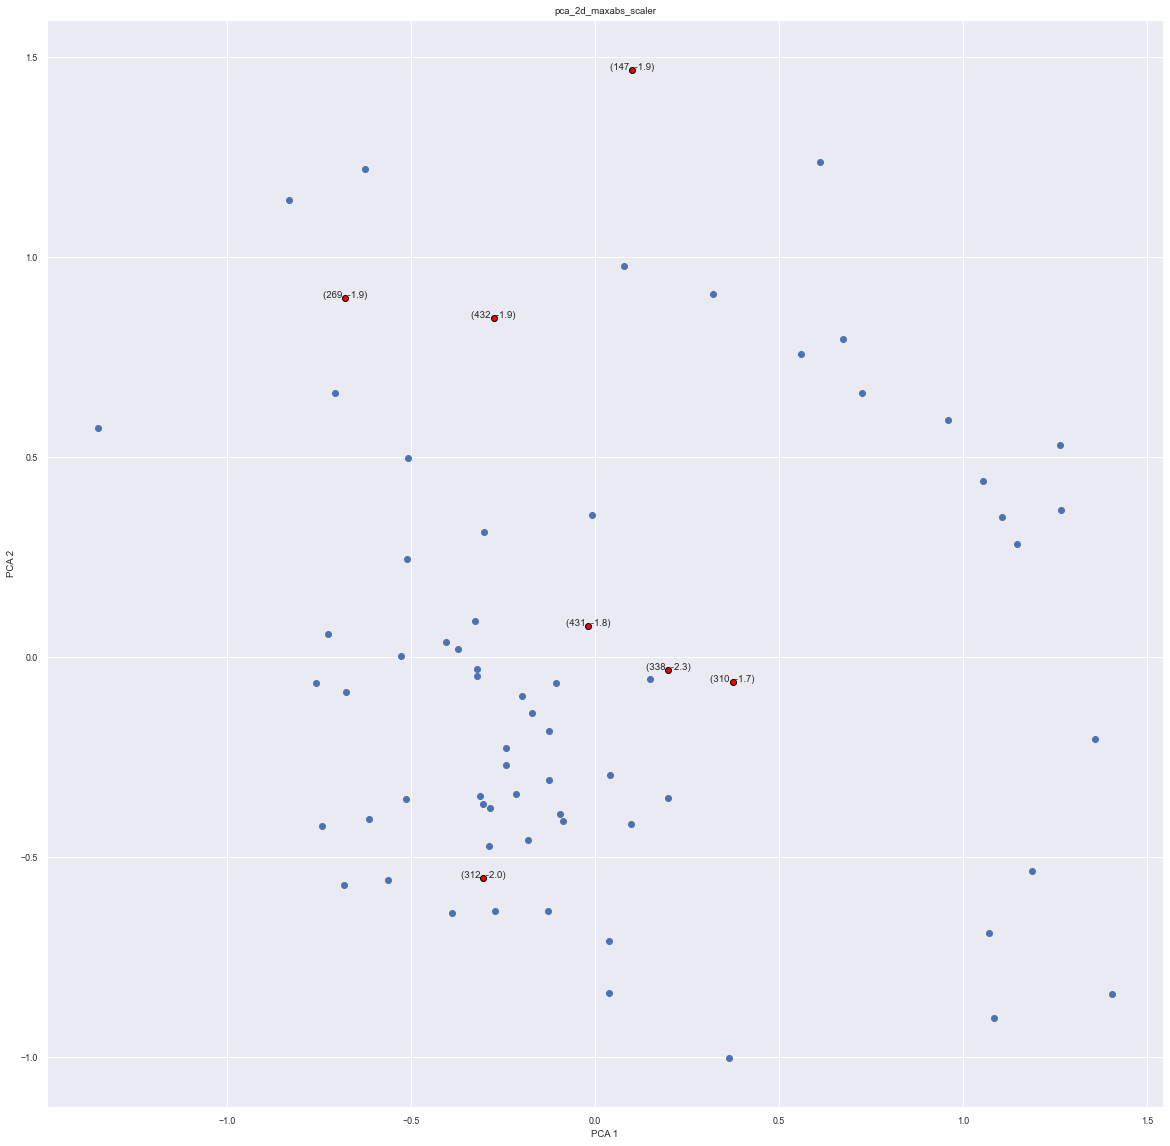

In [27]:
scaler_name = "maxabs_scaler"
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
lof_predict = clf.fit_predict(data_arr)
results = clf.negative_outlier_factor_
data_scaled["LOF"] = results
data_scaled["outlier"] = lof_predict

data_pca = PCA(n_components=2).fit_transform(data_arr)
data_pca = pd.DataFrame(data_pca, columns=["pca1", "pca2"])
df_concat = data_scaled[["ent", "LOF", "outlier"]]
data_pca = pd.concat([df_concat, data_pca], axis=1)

plt.scatter(data_pca["pca1"].loc[(data_pca["outlier"]==1)], data_pca["pca2"].loc[(data_pca["outlier"]==1)])
for i in data_pca["pca1"].loc[(data_pca["outlier"]==-1)]:
    c = 0 # random() * 20
    plt.scatter(i, data_pca["pca2"].loc[data_pca["pca1"]==i], edgecolors="black", color="red") # data_pca["pca1"].loc[(data_pca["LOF"]<=thr)], data_pca["pca2"].loc[(data_pca["LOF"]<=thr)], edgecolors="black", color="red")
    plt.text(i+c, data_pca["pca2"].loc[data_pca["pca1"]==i]+c, 
            ([e for e in data_pca["ent"].loc[data_pca["pca1"]==i]][0], round(float([d for d in data_pca["LOF"].loc[data_pca["pca1"]==i]][0]), 1)), ha="center")
    # print(c)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title(f"pca_2d_{scaler_name}")
name = f"pca_2d_{scaler_name}.png"
path = f"graph/{name}"
fig.savefig(path, dpi=fig.dpi)
fig.clf()
wb = openpyxl.load_workbook("output/pca.xlsx")
if name not in wb.sheetnames:
    ws = wb.create_sheet(name)
else:
    ws = wb[name]
image = openpyxl.drawing.image.Image(path)
ws.add_image(image, "A1")
wb.save("output/pca.xlsx")

df_lof = data_scaled[data_scaled["outlier"]==1]
display(data_scaled.sort_values(by="LOF"))

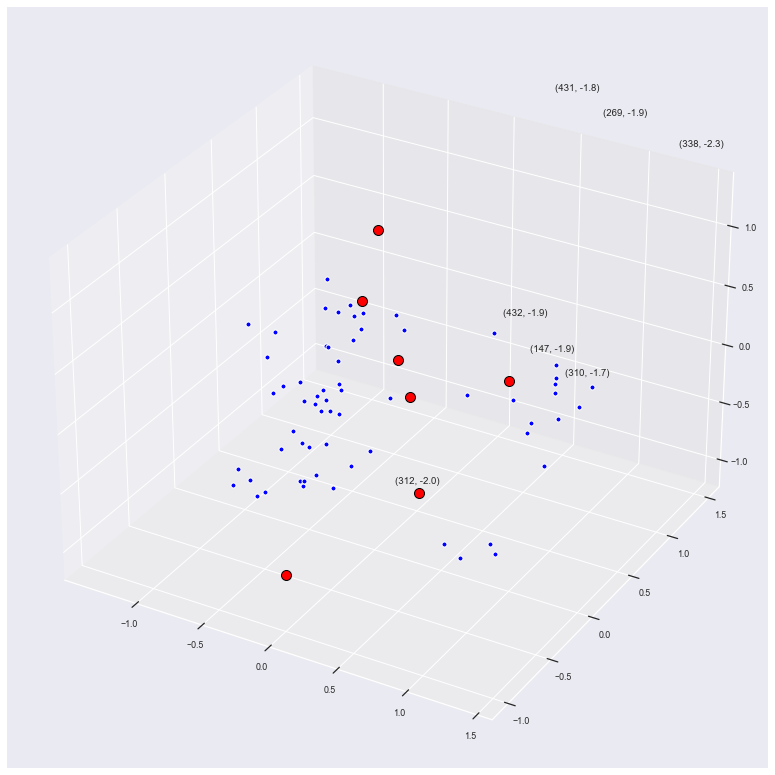

In [10]:
# — — — — — — -Setting Up Color Codes — — — — — — — — — — — -
# colors_plot = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(labels))]

df_pca3_lof = PCA(n_components=3).fit_transform(data_arr)
df_pca3_lof = pd.DataFrame(df_pca3_lof, columns=["pca1", "pca2", "pca3"])
df_concat = data_scaled[["ent", "LOF", "outlier"]]
df_pca3_lof = pd.concat([df_concat, df_pca3_lof], axis=1)

# thr = -12

fig = plt.figure(figsize = (20, 14))
ax = plt.axes(projection ="3d")

for k in range(len(df_pca3_lof)):
    
    ent = df_pca3_lof["ent"].loc[k]
    lof = df_pca3_lof["LOF"].loc[k]
    outlier = df_pca3_lof["outlier"].loc[k]
    pca1 = df_pca3_lof["pca1"].loc[k]
    pca2 = df_pca3_lof["pca2"].loc[k]
    pca3 = df_pca3_lof["pca3"].loc[k]


    # kmeans_cc1 = df_clust["kmeans_cc1"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]
    # kmeans_cc2 = df_clust["kmeans_cc2"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]
    # kmeans_cc3 = df_clust["kmeans_cc3"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]

    if outlier == -1:
    
        ax.plot(
                    pca1,
                    pca2,
                    pca3,
                    "o",
                    markerfacecolor="red",
                    markeredgecolor="black",
                    markersize=10,
                )

        c = random.random() * 2
        ax.text(pca1+c, pca2+c, pca3+c, (ent, round(float(lof), 1)), ha="center")

        '''# — — — — — — -Annotate Centroids — — — — — — — — — — — -
        ax.plot(
                    kmeans_cc1,
                    kmeans_cc2,
                    kmeans_cc3,
                    "o",
                    markerfacecolor=color,
                    markeredgecolor="k",
                    markersize=10,
                )'''

    else:

        ax.plot(
                    pca1,
                    pca2,
                    pca3,
                    "o",
                    markerfacecolor="blue",
                    markeredgecolor="white",
                    markersize=5,
                )
# — — — — — — -Add title to the plot — — — — — — — — — — — -
# plt.title("KMeans with PCA - OUTLIERS not graphed", fontsize=14)
plt.show()

df_pca3_lof = df_pca3_lof[df_pca3_lof["outlier"]==1].drop(["LOF", "outlier"], axis=1)
# df_pca3_lof

In [11]:
'''import numpy as np
import matplotlib.pyplot as plt
from sklearn_extra.cluster import KMedoids
# Import the digits’ dataset available in sklearn.datasets package
# from sklearn.datasets import load_digits
'''"""“””
Instead of using all 64 attributes of the dataset, we use Principal Component Analysis (PCA) 
to reduce the dimensions of features set such that most of the useful information is covered.
“””"""'''
# from sklearn.decomposition import PCA
''' """“””
Import module for standardizing the dataset i.e. rescaling the data such that its has mean of 0 and standard deviation of 1
“””"""'''
# from sklearn.preprocessing import RobustScaler
# Scale the data
# data_scaled = data_arr
# robust_scaler = RobustScaler().fit(data_arr)
# robust_scaler.transform(data_scaled)
'''"""“””
Compute number of output classes i.e. number of digits for which we have the data (here 10 (0-9))
“””"""'''
num_digits = 5 # len(np.unique(dataset.target)) 
data_pca = PCA(n_components=3).fit_transform(data_arr)
display(data_pca.shape)
'''"""“””
PCA constructs new components by linear combinations of original features. 
‘n_components’ parameter denotes the number of newly formed components to be considered. 
fit_transform() method fits the PCA models and performs dimensionality reduction on digit_data.
“””"""'''
h = 0.02 #step size of the mesh 
#Minimum and maximum x-coordinates
xmin, xmax = data_pca[:, 0].min() - 1, data_pca[:, 0].max() + 1
#Minimum and maximum y-coordinates
ymin, ymax = data_pca[:, 1].min() - 1, data_pca[:, 1].max() + 1
#Minimum and maximum z-coordinates
zmin, zmax = data_pca[:, 2].min() - 1, data_pca[:, 2].max() + 1
xx, yy, zz = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h), np.arange(zmin, zmax, h))
models = [
     (
         KMedoids(metric="manhattan", n_clusters=num_digits, 
         init="heuristic", max_iter=1000),"Manhattan metric",
     ),
     (
         KMedoids(metric="euclidean", n_clusters=num_digits,  
         init="heuristic", max_iter=1000),"Euclidean metric",
     ),
     (KMedoids(metric="cosine", n_clusters=num_digits, init="heuristic", 
      max_iter=1000), "Cosine metric", ),
]
#number of rows = integer(ceiling(number of model variants/2))
num_rows = int(np.ceil(len(models) / 2.0))
display(num_rows)
#number of columns
num_cols = 3
#Clear the current figure first (if any)
plt.clf()
#Initialize dimensions of the plot
plt.figure(figsize=(15,10))
'''"""“””
The ‘models’ array defined in step (6) contains three tuples, each having a model variant’s parameters and its descriptive text. 
We iterate through each of the tuples, fit the data to the model and plot the results.
“””"""'''
for i, (model, description) in enumerate(models):
    # Fit each point in the mesh to the model
    model.fit(data_pca)
#Predict the labels for points in the mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()])
    # Put the result  into a color plot
    Z = Z.reshape(xx.shape)
#Subplot for the ith model variant
    plt.subplot(num_cols, num_rows, i + 1)
#Display the subplot
    plt.imshow(
        Z,    #data to be plotted
        interpolation="nearest",
#bounding box coordinates (left,right,bottom,top)
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        cmap=plt.cm.Paired,  #colormap
        aspect="auto", #aspect ratio of the axes
        origin="lower",  #set origin as lower left corner of the axes
    )
    plt.plot(
        data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], "k.", markersize=2, alpha=0.3
    )
    # Plot the centroids as white cross marks
    centroids = model.cluster_centers_
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        centroids[:, 2],
        marker="x",
        s=169,  #marker’s size (points^2)
        linewidths=3, #width of boundary lines
        color="w",  #white color for centroids markings
        zorder=10,  #drawing order of axes
    )
    #describing text of the tuple will be title of the subplot
    plt.title(description)  
    plt.xlim(xmin, xmax)  #limits of x-coordinates
    plt.ylim(ymin, ymax)  #limits of y-coordinates
    plt.ylim(zmin, zmax)  #limits of y-coordinates
    plt.xticks(())   
    plt.yticks(())
    plt.zticks(())
#Upper title of the whole plot
plt.suptitle(
#Text to be displayed
    "K-Medoids algorithm implemented with different metrics\n\n",
    fontsize=20,  #size of the fonts
)
plt.show()'''

'import numpy as np\nimport matplotlib.pyplot as plt\nfrom sklearn_extra.cluster import KMedoids\n# Import the digits’ dataset available in sklearn.datasets package\n# from sklearn.datasets import load_digits\n“””\nInstead of using all 64 attributes of the dataset, we use Principal Component Analysis (PCA) \nto reduce the dimensions of features set such that most of the useful information is covered.\n“””\n# from sklearn.decomposition import PCA\n“””\nImport module for standardizing the dataset i.e. rescaling the data such that its has mean of 0 and standard deviation of 1\n“””\n# from sklearn.preprocessing import RobustScaler\n# Scale the data\n# data_scaled = data_arr\n# robust_scaler = RobustScaler().fit(data_arr)\n# robust_scaler.transform(data_scaled)\n“””\nCompute number of output classes i.e. number of digits for which we have the data (here 10 (0-9))\n“””\nnum_digits = 5 # len(np.unique(dataset.target)) \ndata_pca = PCA(n_components=3).fit_transform(data_arr)\ndisplay(data_pca.

In [12]:
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA

# data_pca = PCA(n_components=3).fit_transform(data_arr)

# df_pca3_lof

k_med = KMedoids(metric="cosine", n_clusters=5, 
         init="heuristic", max_iter=10000, method="pam").fit(df_pca3_lof[df_pca3_lof.columns[1:]])

k_means = KMeans(n_clusters=5, n_init=100, max_iter=10000, algorithm="elkan").fit(df_pca3_lof[df_pca3_lof.columns[1:]])

y_k_med = k_med.fit_predict(df_pca3_lof[df_pca3_lof.columns[1:]])

y_k_means = k_means.fit_predict(df_pca3_lof[df_pca3_lof.columns[1:]])

kmed_labels = k_med.labels_
labels = set(kmed_labels)

kmeans_labels = k_means.labels_

In [13]:
k_med_clust = k_med.cluster_centers_ # PCA(n_components=2).fit_transform(robust_scaler.fit_transform(k_med.cluster_centers_))
k_means_clust = k_means.cluster_centers_ # PCA(n_components=2).fit_transform(robust_scaler.fit_transform(k_means.cluster_centers_))

In [14]:
df_clust = pd.DataFrame(df_pca3_lof, columns=["pca1", "pca2", "pca3"])
df_clust["ent"] = df_pca3_lof["ent"]
df_clust["kmed"] = y_k_med
df_clust["kmeans"] = y_k_means
df_clust["kmed_cc1"] = [k_med_clust[c, 0] for c in df_clust["kmed"]]
df_clust["kmed_cc2"] = [k_med_clust[c, 1] for c in df_clust["kmed"]]
df_clust["kmed_cc3"] = [k_med_clust[c, 2] for c in df_clust["kmed"]]
df_clust["kmeans_cc1"] = [k_means_clust[c, 0] for c in df_clust["kmeans"]]
df_clust["kmeans_cc2"] = [k_means_clust[c, 1] for c in df_clust["kmeans"]]
df_clust["kmeans_cc3"] = [k_means_clust[c, 2] for c in df_clust["kmeans"]]
# df_clust

In [15]:
'''df_explained_variance = data_pca.explained_variance_ratio_
df_explained_variance = np.insert(df_explained_variance, 0, 0)
cumulative_variance = np.cumsum(np.round(df_explained_variance, decimals=3))
pca_variance = pd.DataFrame(['', 'pc1', 'pc2', 'pc3'], columns=['pc'])
df_explained_variance = pd.DataFrame(df_explained_variance, columns=['explained_variance'])
cumulative_variance = pd.DataFrame(cumulative_variance, columns=['cumulative_variance'])
df_explained_variance = pd.concat([pca_variance, df_explained_variance, cumulative_variance], axis=1)
print(df_explained_variance)'''

"df_explained_variance = data_pca.explained_variance_ratio_\ndf_explained_variance = np.insert(df_explained_variance, 0, 0)\ncumulative_variance = np.cumsum(np.round(df_explained_variance, decimals=3))\npca_variance = pd.DataFrame(['', 'pc1', 'pc2', 'pc3'], columns=['pc'])\ndf_explained_variance = pd.DataFrame(df_explained_variance, columns=['explained_variance'])\ncumulative_variance = pd.DataFrame(cumulative_variance, columns=['cumulative_variance'])\ndf_explained_variance = pd.concat([pca_variance, df_explained_variance, cumulative_variance], axis=1)\nprint(df_explained_variance)"

In [16]:
kmed_labels = df_clust["kmed"].unique() # df_clust["ent"][df_clust["kmed"]==0]

'''for label in kmed_labels:
    display(df_clust[df_clust["kmed"]==label])'''

'for label in kmed_labels:\n    display(df_clust[df_clust["kmed"]==label])'

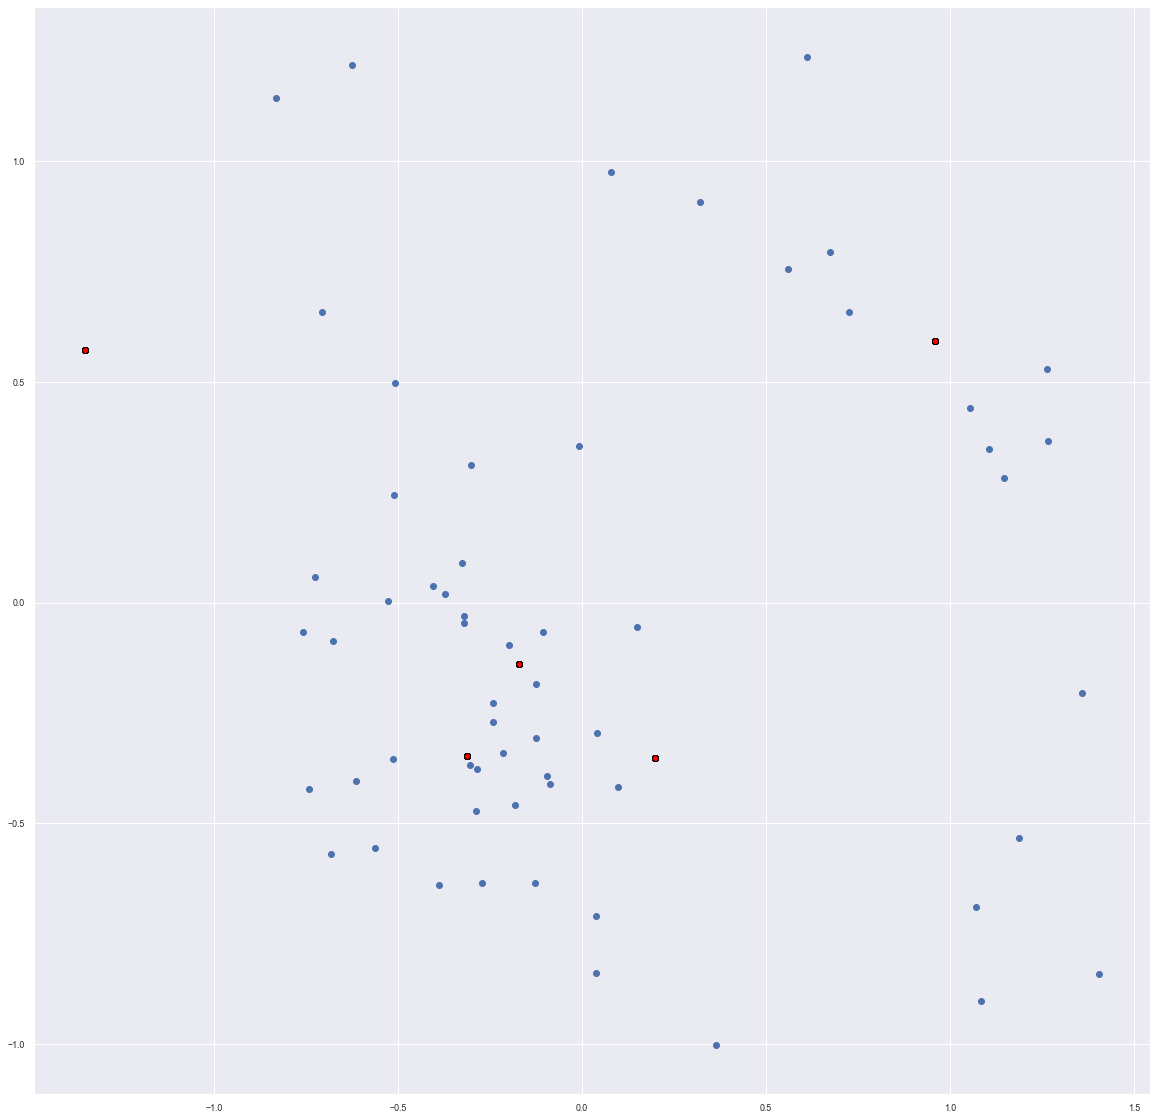

In [17]:
plt.scatter(df_clust["pca1"], df_clust["pca2"])
plt.scatter(df_clust["kmed_cc1"], df_clust["kmed_cc2"], edgecolors="black", color="red")

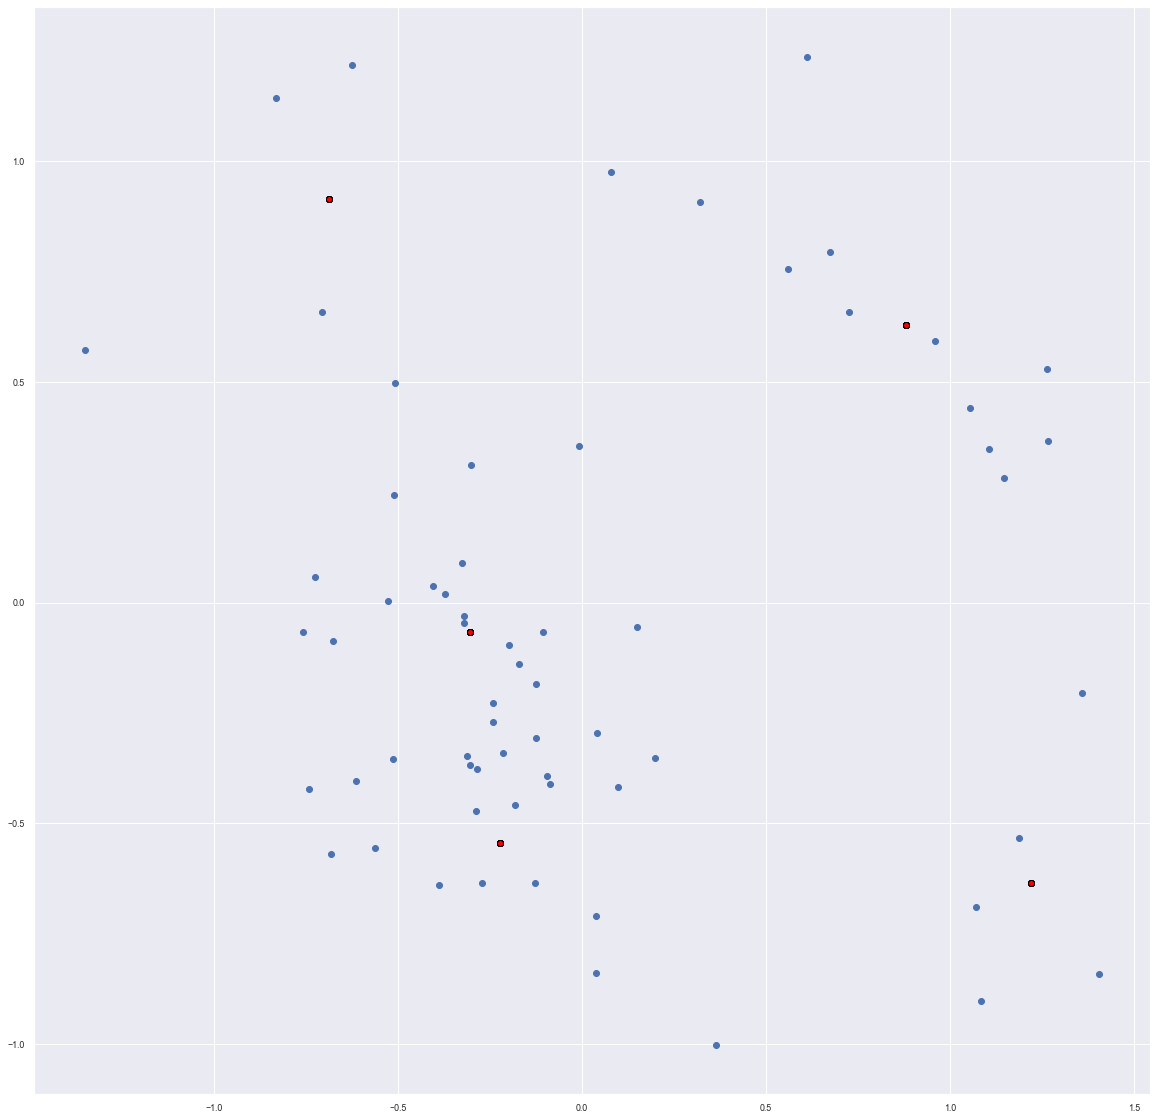

In [18]:
plt.scatter(df_clust["pca1"], df_clust["pca2"])
plt.scatter(df_clust["kmeans_cc1"], df_clust["kmeans_cc2"], edgecolors="black", color="red")

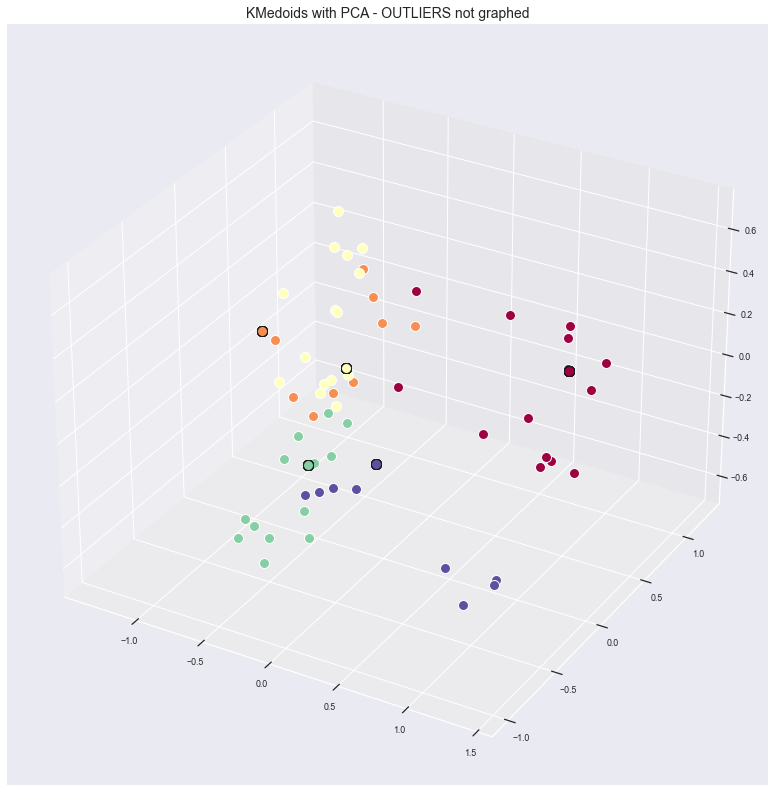

In [19]:
# — — — — — — -Setting Up Color Codes — — — — — — — — — — — -
colors_plot = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(labels))]

fig = plt.figure(figsize = (20, 14))
ax = plt.axes(projection ="3d")

for k, col in zip(labels, colors_plot):
    class_member_mask = df_clust["kmed"] == k
 
    # — — — — — — -Setting datapoint Feature X and Feature Y — — — — — — — — — — — -
    pca1 = df_clust["pca1"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]
    pca2 = df_clust["pca2"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]
    pca3 = df_clust["pca3"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]


    kmed_cc1 = df_clust["kmed_cc1"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]
    kmed_cc2 = df_clust["kmed_cc2"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]
    kmed_cc3 = df_clust["kmed_cc3"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]

    color = tuple(col)
 
    # — — — — — — -Plotting Feature X and Feature Y for each cluster labels — — — — — — — — — — — -
    ax.plot(
                pca1,
                pca2,
                pca3,
                "o",
                markerfacecolor=color,
                markeredgecolor="white",
                markersize=10,
            )

    # — — — — — — -Annotate Centroids — — — — — — — — — — — -
    ax.plot(
                kmed_cc1,
                kmed_cc2,
                kmed_cc3,
                "o",
                markerfacecolor=color,
                markeredgecolor="k",
                markersize=10,
            )
# — — — — — — -Add title to the plot — — — — — — — — — — — -
plt.title("KMedoids with PCA - OUTLIERS not graphed", fontsize=14)
plt.show()

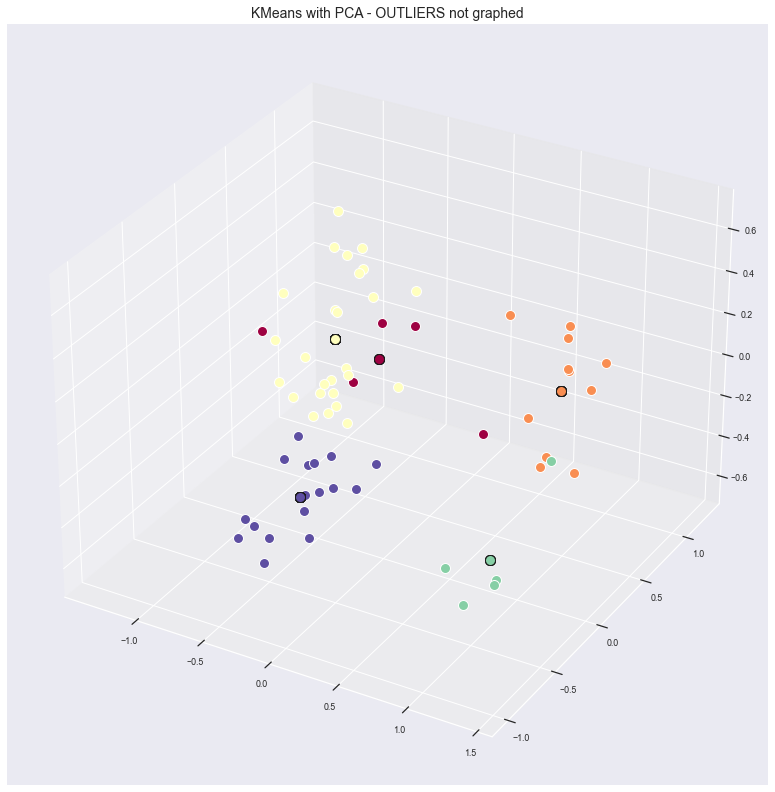

In [20]:
# — — — — — — -Setting Up Color Codes — — — — — — — — — — — -
colors_plot = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(labels))]

fig = plt.figure(figsize = (20, 14))
ax = plt.axes(projection ="3d")

for k, col in zip(labels, colors_plot):
    class_member_mask = df_clust["kmeans"] == k
 
    # — — — — — — -Setting datapoint Feature X and Feature Y — — — — — — — — — — — -
    pca1 = df_clust["pca1"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]
    pca2 = df_clust["pca2"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]
    pca3 = df_clust["pca3"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]


    kmeans_cc1 = df_clust["kmeans_cc1"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]
    kmeans_cc2 = df_clust["kmeans_cc2"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]
    kmeans_cc3 = df_clust["kmeans_cc3"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]

    color = tuple(col)
 
    # — — — — — — -Plotting Feature X and Feature Y for each cluster labels — — — — — — — — — — — -
    ax.plot(
                pca1,
                pca2,
                pca3,
                "o",
                markerfacecolor=color,
                markeredgecolor="white",
                markersize=10,
            )

    # — — — — — — -Annotate Centroids — — — — — — — — — — — -
    ax.plot(
                kmeans_cc1,
                kmeans_cc2,
                kmeans_cc3,
                "o",
                markerfacecolor=color,
                markeredgecolor="k",
                markersize=10,
            )
# — — — — — — -Add title to the plot — — — — — — — — — — — -
plt.title("KMeans with PCA - OUTLIERS not graphed", fontsize=14)
plt.show()

In [21]:
y_k_med

array([2, 1, 2, 3, 1, 3, 3, 2, 2, 2, 4, 1, 1, 2, 3, 3, 2, 3, 3, 2, 1, 2,
       1, 1, 1, 0, 1, 3, 4, 1, 3, 2, 0, 4, 2, 3, 3, 3, 0, 3, 2, 2, 0, 4,
       0, 0, 2, 3, 4, 2, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 2, 4],
      dtype=int64)

In [22]:
k_med.inertia_

8.098090274213313

In [23]:
from sklearn.metrics import silhouette_samples, silhouette_score
silhouette_avg = silhouette_score(data_arr, y_k_med)
print(silhouette_avg)

ValueError: Found input variables with inconsistent numbers of samples: [71, 64]

In [ ]:
sample_silhouette_values = silhouette_samples(data_pca, y_k_med)
for i in range(3):
    ith_cluster_silhouette_values = sample_silhouette_values[y_k_med == i]
    print(np.mean(ith_cluster_silhouette_values))